<a href="https://colab.research.google.com/github/Kasaligan/Machine-Learning-UNS/blob/main/TP7/Clase_7_Reduccion_de_Dimensionalidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IDEA

Para el siguiente TP voy a reanalizar algunos datasets de ejercicios anteriores, sobre los cuales visualmente intuia podrian eliminarse variables o combinar otras. 

Luego de buscar bastante al respecto me baso en la informacion del siguiente link:

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

En el se presentan varios metodos de reduccion de dimensionalidad. Me restrinjo a aplicar solo aquellos que realmente entiendo.

Aplicare por separado metodos de filtrado y metodos "envolventes". No probare metodos embebidos pues estos, de existir, vienen incluidos con cada metodo de machine learning optimizando para ese metodo particular.

#DATASETS

Trabajare con los datasets del TP4 y TP6. En el TP4 el dataset era sobre diagnosticos en cancer de mama. Use todas las variables puesto que no sabia sobre el tema y tal vez eliminaria a ojo de forma erronea variables. En el TP6 trabaje con los precios de casas de Boston. Habia parametros que consideraba innecesarios, pero carecia de las herramientas para justificar su eliminacion. 

#EVALUACION

En ambos casos tomare solo el modelo mas exitoso del trabajo correspondiente. Considerare que la reduccion fue exitosa si logro una performance igual o mejor a la original.


#CRITERIOS DE REDUCCION

En el enlace se encuentra la siguiente imagen a modo de resumen la cual considero es mejor que cualquier explicacion que pueda hacer.
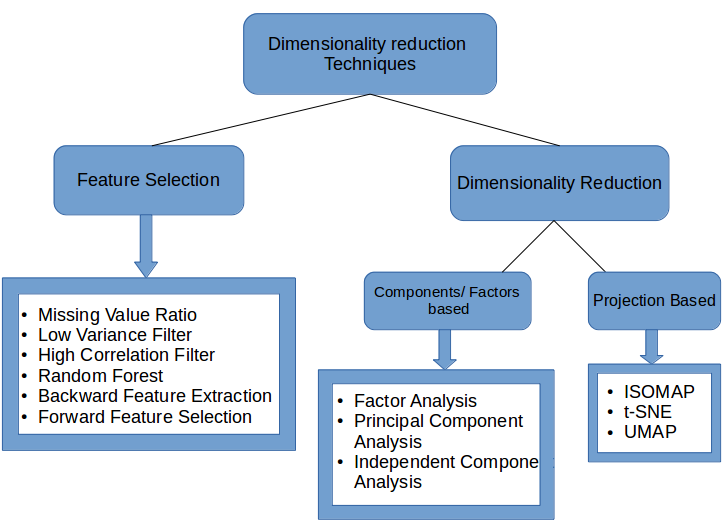

##Reduccion por filtrado

Cada metrica para el filtrado elimina aquellas dimensiones que sobrepasen un valor umbral. En vez de usar una metrica en particular hare uso de todas para la evaluacion. Podria decirse que es un filtrado muy "esceptico". El orden esta pensado para minimizar el esfuerzo computacional (los metodos mas costosos trabajan con el dataset ya reducido).

- ### Missing Value Ratio:
Segun recuerdo no habia muchos datos faltantes en los datasets, pero analizare nuevamente y eliminare aquellos parametros que tengan al menos un 40% de datos faltantes. Si una columna con datos faltantes no es eliminada estos seran imputados luego de terminar con todo el filtrado.
- ### High Correlation Filter With Target:
Aanalizare la correlacion con la variable target y eliminare directamente aquellas que tengan menos del 15% de correlacion. 
- ### High Correlation Filter Between Parameters:
Analizare la correlacion entre cada uno de los parametros de los datos y eliminare aquellas con correlacion superior al 80%. 
- ### Low Variance Filter: 
Este criterio elimina los parametros con bajas varianzas respecto al resto. Si bien esto es bastante util, es necesario comparar a ojo (en principio) para saber cuales parametros eliminar. Mi idea era calcular las varianzas de todos los parametros y como criterio para automatizar esto ordenar las varianzas de menor a mayor y buscar un salto de DOS ordenes de magnitud (criterio completamente subjetivo). Todas las variables con varianzas por debajo de este salto serian eliminadas. Esto sin embargo es bastante subjetivo y podrian haber saltos mas importantes despues del corte automatico. Por esto decidi no implementar este criterio como filtro.

##Reduccion por "envolvente" (wrapper)

En estos casos se va probando añadiendo/eliminando variables al metodo de trabajo elegido (random forests, regresion, clustering, etc) hasta que la mejora en performance (segun el parametro elegido) es minima. El downside es que requieren un costo computacional alto pues prueban todas las combinaciones posibles antes de decidirse por un parametro. 
No hay un metodo universal que haya encontrado por lo que mi idea era al igual que con los metodos de filtrado implementarlo yo mismo y dejar preparadas funciones que pueda simplemente importar a cualquier codigo. Dejo esto para desarrollo futuro considerando la fecha a la que estamos y que para cada uno de estos metodos deberia crear una funcion que sea compatible con distintos metodos de los vistos (como random forest, metodos de regresion, metodos de clustering, etc). Es algo que voy a hacer seguramente pues va a tener mucha utilidad, pero para hacerlo bien y que sea lo mas generico posible en cuanto a metodos base va a llevar tiempo. 

- ### Foward Step Selection: 
Se prueba el modelo a usar con cada variable y se conserva la que mejor resultados da. Luego se prueba agregando cada una de las restantes y se conserva la que mas contribuye a la performance y asi hasta que la mejora en performance sea minima. 
- ### Backwards Step Elimination:
Similar al metodo anterior pero en vez de probar agregando variables se comienza del total y se van eliminando hasta que la caida en performance no sea aceptable.

#IMPORTO LIBRERIAS

In [262]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import Perceptron     
from sklearn.ensemble import BaggingClassifier     
import sklearn.metrics as skm 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random 

#PREPARACION DE LOS METODOS

Ya que voy a utilizar dos veces cada criterio y es probable que vuelva a utilizarlos en el futuro preparo funciones que luego pueda importar e invocar.

In [263]:
#The following method eliminates atributes from a dataset if the percentage of NaN values surpasses a given threshold.
#Requires pandas library.

def missing_value_percentage_filter(df, threshold=100,axis=0,inplace=False,show_percentages=False,show_erased_atributes=False):    
  #Parameters description:
  #   - df: base dataframe 
  #   - threshold: percentage threshold above which the method will filter atributes. Mustt be in range 0<=threshold<=100 
  #   - axis: choose "1" for atributes in rows, "0" for atributes in columns
  #   - inplace: Boolean. False will return processed dataframe, True will overwrite base dataframe
  #   - show_percentages: shows the NaN percentages for each variable
  #   - show_erased_atributes: shows the erased atributes based on the NaN percentage threshold

  if type(inplace)!=bool:                           #checks if inplace parameter is boolean
    print('Inplace parameter must be boolean.')
    return
  if threshold>100 or threshold<0:                              #checks if threshold is in correct range
    print('Threshold value must be between 0 and 100.')
    return

  null_percentage=df.isnull().sum(axis=axis)*100/len(df)              #calculates the NaN percentage for the atributes
  if show_percentages==True:
    print('NaN percentages: \n', null_percentage)
  threshold_index=null_percentage[null_percentage>threshold].index    #recovers index of atributes above the threshold
  if show_erased_atributes==True:
    print('Erased atributes: ',threshold_index)                     #informs erased atributes
  if inplace==True:                                               #overwrites base dataset or returns result dataset acording to inplace parameter  
    df.drop(threshold_index,axis=1,inplace=inplace)             
  elif inplace==False:
    return df.drop(threshold_index,axis=1,inplace=inplace)

In [264]:
#The following method eliminates atributes from a dataset if the absolute value of the Pearson correlation (R) with target variable is below a certain threshold.
#Example: if threshold is set to 0.3, all atributes whose R correlation with target variable in the range (-0.3,0.3) will be erased. 
#Requires pandas library.

def target_correlation_filter(df,target, threshold=0,axis=0,inplace=False,show_correlations=False,show_erased_atributes=False): 
  #Parameters description: 
  #   - df: base dataframe 
  #   - target: target dataframe to correlate with
  #   - threshold: R threshold below which the method will filter atributes. Mustt be in range 0<=threshold<=1 
  #   - inplace: Boolean. False will return processed dataframe, True will overwrite base dataframe
  #   - show_correlations: shows the correlations with target for each variable
  #   - show_erased_atributes: shows the erased atributes based on the NaN percentage threshold

  correlation_method='pearson'    #correlation method for corrwith is defined here, this function could be modified to allow different correlation methods

  if type(inplace)!=bool:                           #checks if inplace parameter is boolean
    print('Inplace parameter must be boolean.')
    return
  if abs(threshold)>1:                              #checks if threshold is in correct range
    print('Threshold value must be between -1 and 1.')
    return


  correlation_percentage=df.corrwith(target,axis=axis,method=correlation_method)  #calculate correlation vector with target variable
  if show_correlations==True:
    print('Correlations with target: \n', correlation_percentage)                   #show correlations with target
  correlation_percentage=abs(correlation_percentage)                              #aply absolute value to the correlation vector
  threshold_index=correlation_percentage[correlation_percentage<threshold].index  #recover index of atributes with absolute correlations below threshold
  if show_erased_atributes==True:
    print('The following parameters have been erased: ',threshold_index)            #show erased parameters
  if inplace==True:         #overwrites base dataset or returns result dataset acording to inplace parameter 
    df.drop(threshold_index,axis=1,inplace=inplace)
  elif inplace==False:
    return df.drop(threshold_index,axis=1,inplace=inplace)


In [265]:
#The following method eliminates dataframe atributes based on a Pearson correlation (R) threshold which can be positive or negative.
#If positive the method eliminates atributes with correlations above said threshold. If negative the method eliminates atributes with correlations below the threshold.
#Atributes must be in COLUMNS
#Requires pandas library and numpy library as np

def autocorrelation_filter(df, threshold=1,inplace=False,show_correlations=False,show_erased_atributes=False):      
  #Parameters description: 
  #   - df: base dataframe 
  #   - threshold: R threshold above or below (depending on sign + or -) which the method will filter atributes. Mustt be in range -1<=threshold<=1 
  #   - inplace: Boolean. False will return processed dataframe, True will overwrite base dataframe
  #   - show_correlations: shows the correlation matrix
  #   - show_erased_atributes: shows the erased atributes based on the NaN percentage threshold
  
  if type(inplace)!=bool:                           #checks if inplace parameter is boolean
    print('Inplace parameter must be boolean.')
    return
  if abs(threshold)>1:                              #checks if threshold is in correct range
    print('Threshold value must be between -1 and 1.')
    return

  correlation_method='pearson'      #this function can be modified to allow different correlation methods, though it's not currently implemented

  correlation_matrix=df.corr(method=correlation_method) #calculate correlation matrix

  if show_correlations==True:
    print('Correlation matrix: \n', correlation_matrix)

  if threshold<0:                                       #in case threshold is negative 
    correlation_matrix=-1*correlation_matrix            #correlation matrix and threshold sings are inverted 
    threshold=-threshold                                #this way the code is the same as if threshold was positive

  np.fill_diagonal(correlation_matrix.values, 0)    #autocorrelations are replaced with zero

  correlation_bool=correlation_matrix.copy()        #auxiliary dataframe
  correlation_bool[correlation_bool<threshold]=0    #correlations below threshold are replaced with zero
  correlation_bool[correlation_bool>=threshold]=1   #correlations above or equal to threshold are replaced with one

  if inplace==True:
    df_aux=df             #in case inplace is True modify original dataframe
  elif inplace==False:
    df_aux=df.copy()      #if not create a new dataframe which will be returned at the end
  
  correlations_dumb_total=correlation_bool.sum() #stores the total number of correlations that surpass the threshold for each atribute
  
  #this is done without considering the actual correlation values, which is why it's a "dumb" total

  erased_parameters=np.array([])    #dataframe to store and later inform erased atributes

  while correlations_dumb_total.any().any():       #while there are still correlations above threshold

    parameter_index=np.array(np.where(correlations_dumb_total==max(correlations_dumb_total)))[0] #atribute index with the maximum number of correlations above threshold  
    #np.where returns a tuple, which I here change into a one-dimensional array
    
    if np.size(parameter_index)>1:    #if more than one atribute has the maximum number of correlations above threshold
      correlation_comparative=correlation_matrix.iloc[:,parameter_index].sum() #calculate the sum of the correlations above threshold for each of the atributes of interest
      aux_index=np.array(np.where(correlation_comparative==max(correlation_comparative)))[0] #obtain the index of the maximum of these correlation sums
      #np.where returns a tuple, which I here change into a one-dimensional array      
      aux_index=aux_index[0]       #access the actual number of the array
      parameter_index=parameter_index[aux_index]     #select the atribute index based on previous step
    
    erased_parameters=np.append(erased_parameters,df_aux.columns[parameter_index])   #add the soon to be erased parameter to a list for future reference

    #these next lines erase the atribute from all matrixes of interest
    correlation_matrix.drop(correlation_matrix.columns[parameter_index],axis=1,inplace=True)
    correlation_matrix.drop(correlation_matrix.index[parameter_index],axis=0,inplace=True)    
    correlation_bool.drop(correlation_bool.columns[parameter_index],axis=1,inplace=True)
    correlation_bool.drop(correlation_bool.index[parameter_index],axis=0,inplace=True)
    df_aux.drop(df_aux.columns[parameter_index],axis=1,inplace=True) 

    #Calculate remaining correlations above threshold, sum them and repeat until no correlation remains above threshold      
    correlations_dumb_total=correlation_bool.sum()

  if show_erased_atributes==True:
    print('The following parameters have been erased: ', erased_parameters) #inform which atributes have been deleted

  if inplace==False:  #if inplace=True the base dataframe has already been actualized, if not then return the modified dataframe
    return df_aux
  

#TP4 - CANCER DE MAMA

Para este analisis voy a importar el mismo dataset. Separare la variable target del resto de los atributos y luego implementare los tres metodos que prepare para filtrar variables. Una vez logrado implementare nuevamente el modelo 2 de ese trabajo. En ese TP el mas exitoso fue el modelo 3, pero este implementa bagging y no puede asegurarse que siga el mismo camino todas las veces. Por el contrario el modelo 2 puede implementarse con una semilla en los perceptrones. 

In [266]:
#Importo el dataset
cancer_tissues = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBCD/data/data.csv")
cancer_tissues.head()

#Mezclo el dataset. 
#Al particionar el dataset no lo mezclare en ese momento asi los datos de train y test para el modelo con y sin filtrado de atributos tendran 
#las mismas columnas.
cancer_tissues = shuffle(cancer_tissues)

#A continuacion aislo la columna "diagnosis" que sera nuestro target. 
#Para los datos descarto la columna "ID" que no contiene informacion relevante, y la columna "Unnamed: 32" que dios sabra porque esta ahi. 
target = cancer_tissues.loc[:,'diagnosis']
data = cancer_tissues.drop(['diagnosis', 'id','Unnamed: 32'], axis=1)

#Particiono el dataset
test_size=0.5   #fraccion del dataset que se usa para testeo
[data_train_original,data_test_original,target_train_original,target_test_original] = train_test_split(data,target,test_size=test_size,shuffle=False)

#A este punto tengo el dataset original separado en data y target y separado a su vez en test y train.

In [267]:
#Proceso del dataset cancer_tissues con los filtros

#Filtro de valores faltantes
cancer_tissues_filtered = missing_value_percentage_filter(data,threshold=50,show_erased_atributes=True)

Erased atributes:  Index([], dtype='object')


In [268]:
#Filtro de correlaciones con target

#El filtro solo admite targets numericos continuos, y si es categorico debe ser una categoria binaria.
#En este caso la categoria target es binaria (benigno/maligno) por lo que le asigno valores 0 y 1 y asi computo la correlacion.

target_aux=target.copy()
target_aux[target_aux=='B']=0
target_aux[target_aux=='M']=1
target_aux=target_aux.astype(float)
#cambio los elementos del dataframe target que quedaron como "int" a "float", sino no funciona el metodo df.corrwith que esta dentro de mi funcion

target_correlation_filter(df=cancer_tissues_filtered,target=target_aux,axis=0,threshold=0.15,inplace=True,show_erased_atributes=True)

The following parameters have been erased:  Index(['fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se',
       'fractal_dimension_se'],
      dtype='object')


In [269]:
#Filtro de autocorrelaciones
autocorrelation_filter(df=cancer_tissues_filtered,threshold=0.99,inplace=True,show_erased_atributes=True)

The following parameters have been erased:  ['perimeter_worst' 'perimeter_mean']


In [270]:
print('El dataset previo al filtrado tenia ',len(data.columns),' atributos.\n')
print('El dataset luego del filtrado tiene ',len(cancer_tissues_filtered.columns),' atributos.\n')

El dataset previo al filtrado tenia  30  atributos.

El dataset luego del filtrado tiene  23  atributos.



Ahora solo queda particionar el dataset filtrado en train y test.

In [271]:
#Particiono el dataset
test_size=0.5   #fraccion del dataset que se usa para testeo
[data_train_filtrado,data_test_filtrado,target_train_filtrado,target_test_filtrado] = train_test_split(cancer_tissues_filtered,target,test_size=test_size,shuffle=False)
random_state=random.randint(0,1000000)   #Con esto todos los modelos tendran la misma semilla, aunque cambiara en cada ejecucion

## EVALUACION


> #### MODELO ORIGINAL

In [272]:
max_iter=1000  #numero de epocas
eta0=1  #constante para multiplicar las updates: mientras menor es mas preciso sera el resultado final pero requerira mas iteraciones para converger
random_state=random.randint(0,1000000)   #Con esto todos los modelos tendran la misma semilla, aunque cambiara en cada ejecucion
ppn = Perceptron(max_iter=max_iter , eta0=eta0, random_state=random_state)  #creo el modelo
labels=['B','M']  #etiquetas target
pos_label='M'     #target positivo

In [273]:
mod_2=ppn.fit(data_train_original,target_train_original)    #entreno el modelo 
prediccion_2=mod_2.predict(data_test_original)     #guardo las predicciones del modelo
exact_2_original=skm.accuracy_score(target_test_original,prediccion_2)  #calculo exactitud
prec_2_original=skm.precision_score(target_test_original,prediccion_2,labels=labels,pos_label=pos_label)  #calculo precision
f_2_original=skm.f1_score(target_test_original,prediccion_2,labels=labels,pos_label=pos_label)            #calculo f-measure

print("Exactitud: ",exact_2_original,"\nPrecision: ",prec_2_original,"\nF-measure: ",f_2_original)

Exactitud:  0.8736842105263158 
Precision:  0.7666666666666667 
F-measure:  0.8363636363636363


In [274]:
mod_filtrado=ppn.fit(data_train_filtrado,target_train_filtrado)    #entreno el modelo 
prediccion_filtrado=mod_filtrado.predict(data_test_filtrado)     #guardo las predicciones del modelo
exact_filtrado=skm.accuracy_score(target_test_filtrado,prediccion_filtrado)  #calculo exactitud
prec_filtrado=skm.precision_score(target_test_filtrado,prediccion_filtrado,labels=labels,pos_label=pos_label)  #calculo precision
f_filtrado=skm.f1_score(target_test_filtrado,prediccion_filtrado,labels=labels,pos_label=pos_label)            #calculo f-measure

print("Exactitud: ",exact_filtrado,"\nPrecision: ",prec_filtrado,"\nF-measure: ",f_filtrado)

Exactitud:  0.8070175438596491 
Precision:  0.6618705035971223 
F-measure:  0.7698744769874477


In [275]:
print(cancer_tissues_filtered.columns)

Index(['radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'radius_worst',
       'texture_worst', 'area_worst', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'concave points_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


##CONCLUSION

Debo aclarar antes que nada que deberia utilizar mas metricas para evaluar los modelos, cosa que tal vez haga una vez entregado el TP. De hecho estuve leyendo luego de entregar el trabajo 6 sobre metricas de evaluacion y encontre un paper muy lindo explicando posibles metricas el cual quisiera probar, pero no es el momento. Las siguientes conclusiones son en base a los estimadores que utilice en el trabajo anterior y la evaluacion de "calidad" es solo en base a esos parametros.

En primer lugar este dataset no tenia datos faltantes, por lo que el primer filtro no tuvo efecto.
En este dataset particular la eliminacion de parametros con bajo medulo de correlacion de Pearson R no afecta la calidad del resultado. De esta forma podemos reducir el numero de variables de 30 a 25 sin que afecte en absoluto en la performance. Al incrementar el umbral de correlacion empiezan a eliminarse mas atributos del dataset y la performance empieza a fluctuar entre mejor y peor. Para corroborar esto deberia tener un dataset mas grande de forma que el muestreo del mismo para testeo y entrenamiento no afecte en gran medida al modelo implementado.
Por otro lado el filtro basado en correlaciones entre atributos claramente no es el adecuado en este caso. Incluso poniendo que se eliminen correlaciones superiores a R=0.99 la performance es demasiado caotica y en general baja respecto al modelo completo.

Como conclusion de esta primera parte: el filtro de correlacion logro una mejora al disminuir el numero de variables a procesar sin empeorar la performance para valores umbrales razonables.

#TP6 - BOSTON HOUSING

Para este analisis voy a importar el mismo dataset. Separare la variable target del resto de los atributos y luego implementare los tres metodos que prepare para filtrar variables. Una vez logrado implementare nuevamente el modelo 2 de ese trabajo. En ese TP no hubo un metodo superior a los demas, por lo que utilizare el metodo de regresion lineal que es el mas facil de asegurar sigue el mismo algoritmo y de comparar.

In [276]:
#importo el dataset, hago shuffle 
true_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBHP/data/housing_data.csv")
true_news = shuffle(true_news)

Implemento filtro NaN

In [277]:
missing_value_percentage_filter(df=true_news,threshold=50,inplace=True,show_percentages=True,show_erased_atributes=True)

NaN percentages: 
 CRIM       3.952569
ZN         3.952569
INDUS      3.952569
CHAS       3.952569
NOX        0.000000
RM         0.000000
AGE        3.952569
DIS        0.000000
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
LSTAT      3.952569
MEDV       0.000000
dtype: float64
Erased atributes:  Index([], dtype='object')


Como no hay una cantidad de valores faltantes muy grande continuo. Vuelvo a hacer el mismo preprocesamiento de los datos para eliminar datos censurados e imputar valores NaN que hice en el TP6, esta vez combinado con los filtros.

In [278]:
#elimino datos censurados
cens_index=true_news[true_news['MEDV']==50].index        #recupero solo los indices que corresponden
true_news=true_news.drop(cens_index, axis=0)    #elimino las filas con NaN}

#imputo los valores NaN
from sklearn.impute import KNNImputer   
n_neighbors=round(np.sqrt(len(true_news)))
imp=KNNImputer(n_neighbors=n_neighbors)     #preparo el imputador
#aplico el imputador y cambio el nombre a uno mejor para el problema. Debo notar que el imputador devuelve un arreglo numpy, por lo que 
#debo pasarlo manualmente a dataframe
houses=pd.DataFrame(imp.fit_transform(true_news),columns=true_news.columns)     
#confirmo la transformacion
a=houses.isnull()   #devuelve un dataframe con valores true/false segun si tiene/no tiene valor NaN la celda
b=a.any(axis=1)   #devuelve un dataframde de una sola columna, donde indica con true/false si la fila del dataset "a" contenia al menos un TRUE (valor nan)
print(houses[b].index)   #toma las filas segun el indice true/false de "b", e imprime el indice resultante (los umeros de filas co NaN)
print(houses)

#Separo target de data
target_original=houses.loc[:,'MEDV']
data_original=houses.drop(['MEDV'],axis=1)

#Preparo otro dataset para filtrar
houses_filter=houses.copy()

Int64Index([], dtype='int64')
         CRIM   ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0     0.11432  0.0   8.56   0.0  0.520  ...  384.0     20.9  395.58   7.67  26.5
1     2.37934  0.0  19.58   0.0  0.871  ...  403.0     14.7  172.91  27.80  13.8
2     9.33889  0.0  18.10   0.0  0.679  ...  666.0     20.2   60.72  24.08   9.5
3     9.32909  0.0  18.10   0.0  0.713  ...  666.0     20.2  396.90  18.13  14.1
4     1.65660  0.0  19.58   0.0  0.871  ...  403.0     14.7  372.80  14.10  21.5
..        ...  ...    ...   ...    ...  ...    ...      ...     ...    ...   ...
485   0.53700  0.0   6.20   0.0  0.504  ...  307.0     17.4  378.35  11.65  24.3
486   0.13914  0.0   4.05   0.0  0.510  ...  296.0     16.6  396.90  14.69  23.1
487  14.05070  0.0  18.10   0.0  0.597  ...  666.0     20.2   35.05  21.22  17.2
488   8.71675  0.0  18.10   0.0  0.693  ...  666.0     20.2  391.98  17.12  13.1
489   0.04684  0.0   3.41   0.0  0.489  ...  270.0     17.8  392.18   8.81  22.

In [279]:
#implemento el filtro de autocorrelacion
autocorrelation_filter(df=houses_filter,threshold=0.95,inplace=True,show_correlations=True,show_erased_atributes=True)

Correlation matrix: 
              CRIM        ZN     INDUS  ...         B     LSTAT      MEDV
CRIM     1.000000 -0.202558  0.420442  ... -0.392543  0.462974 -0.454471
ZN      -0.202558  1.000000 -0.530072  ...  0.177596 -0.424312  0.407958
INDUS    0.420442 -0.530072  1.000000  ... -0.369647  0.624206 -0.599971
CHAS    -0.062775 -0.051465  0.024741  ...  0.046671 -0.002539  0.079848
NOX      0.423602 -0.514439  0.764144  ... -0.383087  0.612265 -0.524451
RM      -0.219328  0.313239 -0.406645  ...  0.119204 -0.607450  0.686634
AGE      0.358965 -0.565872  0.635545  ... -0.283772  0.635317 -0.494358
DIS     -0.385251  0.669297 -0.712788  ...  0.299426 -0.537718  0.368813
RAD      0.635556 -0.308764  0.609931  ... -0.451534  0.510327 -0.476296
TAX      0.591307 -0.302574  0.732076  ... -0.448211  0.567431 -0.572442
PTRATIO  0.291093 -0.390744  0.396305  ... -0.173636  0.359449 -0.518641
B       -0.392543  0.177596 -0.369647  ...  1.000000 -0.365950  0.364928
LSTAT    0.462974 -0.424312  

Podemos ver que ningun par de atributos tienen autocorrelacion superior a R=0.95 (R^2=0.9)

In [280]:
#Separo target de data
target_filter=houses_filter.loc[:,'MEDV']
data_filter=houses_filter.drop(['MEDV'],axis=1)

In [281]:
#implemento filtro de correlacion con target, uso un umbral |R|<0.15
target_correlation_filter(df=data_filter,target=target_filter,axis=0,threshold=0.15,inplace=True,show_correlations=True,show_erased_atributes=True)

Correlations with target: 
 CRIM      -0.454471
ZN         0.407958
INDUS     -0.599971
CHAS       0.079848
NOX       -0.524451
RM         0.686634
AGE       -0.494358
DIS        0.368813
RAD       -0.476296
TAX       -0.572442
PTRATIO   -0.518641
B          0.364928
LSTAT     -0.752859
dtype: float64
The following parameters have been erased:  Index(['CHAS'], dtype='object')


Separo conjuntos de entrenamiento y testeo.

In [282]:
#Recordemos que el dataset se mezclo al invocarlo, no mezclo al particionar para que esten las mismas muestras en dataset filtrado y original.
test_size=0.5   #fraccion del dataset que se usa para testeo
[data_train_original,data_test_original,target_train_original,target_test_original] = train_test_split(data_original,target_original,test_size=test_size,shuffle=False)
[data_train_filter,data_test_filter,target_train_filter,target_test_filter] = train_test_split(data_filter,target_filter,test_size=test_size,shuffle=False)

Finalmente implemento la regresion lineal.

In [283]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()

In [284]:
#Para el dataset completo:
lr.fit(data_train_original,target_train_original)
r_sqr_final=lr.score(data_test_original,target_test_original)  #obtengo el coeficiente R^2
print('El regresor lineal original tiene un coeficienre R^2 de ', r_sqr_final)

lr.fit(data_train_filter,target_train_filter)
r_sqr_final=lr.score(data_test_filter,target_test_filter)  #obtengo el coeficiente R^2
print('El regresor lineal con datos filtrados tiene un coeficienre R^2 de ', r_sqr_final)

El regresor lineal original tiene un coeficienre R^2 de  0.7112473431644413
El regresor lineal con datos filtrados tiene un coeficienre R^2 de  0.7131060353178629


Y para ver aca la cantidad de atributos que quedan en pie.

In [285]:
print('El dataset previo al filtrado tenia ',len(data_original.columns),' atributos.\n')
print('El dataset luego del filtrado tiene ',len(data_filter.columns),' atributos.\n')

El dataset previo al filtrado tenia  13  atributos.

El dataset luego del filtrado tiene  12  atributos.



##CONCLUSION

El dataset no presentaba muchas correlaciones bajas con la variable target, solo una la cual fue filtrada. Aparte de esto no habia grandes autocorrelaciones entre atributos y el porcentaje de parametros NaN no ameritaba eliminar parametros. 

La performance eliminando el unico atributo que cumplia con los umbrales seleccionados aumento ligeramente respecto al modelo completo, lo cual es buena señal.

Aun asi este filtrado de atributos no puede compensar la malisima calidad del dataset. Hubiera elegido otro si supiera, porque hasta me tope con bastante gente en internet diciendo tambien que es horrible. 

Yo lo quemaria. 

Gracias.